In [13]:
import requests, pandas as pd, matplotlib.pyplot as plt

In [14]:
BASE_URL = "http://127.0.0.1:8888/data-filter"

In [15]:
payload = {
    "content":  ['cost', 'rent', 'price', 'grocery', 'transport', 'bill', 'living', 'wage', 'income', 'expensive', 'afford', "renting", "apartment", "real estate", "landlord", "tenant", "lease", "mortgage", "housing", "electricity", "gas", "water", "utility", "power bill", "food", "meal", "dining", "supermarket", "shopping", "financial", "budget", "ripoff", "overpriced", "cheapest", "cheaper", "cheap", "struggle", "student loan", "university", "school", "tuition", "doctor", "hospital", "medicare", "insurance", "healthcare", "uber", "taxi", "public transport", "car", "petrol", "fuel"],   # data.content
    "tags":     [],     # data.tags
    "keywords": [],     # keywords
    "combine":  "or",      # "and" | "or"
    "size":     1000,
    "max_docs": 200000       # maximum return data
}

In [16]:
resp = requests.post(BASE_URL, json=payload, timeout=120)
resp.raise_for_status()

data = resp.json()
print("Total hits:", data["total"])

命中总数: 200000


In [17]:
docs = resp.json()["data"]
records = []
for d in docs:
    record = {
        "sentiment": d.get("sentiment"),
        "platform": d.get("platform"),
        "_id": d.get("_id"),
        "sentimentLabel": d.get("sentimentLabel"),
        "keywords": d.get("keywords"),
        "tags": d.get("data", {}).get("tags"),
        "createdAt": d.get("data", {}).get("createdAt"),
    }
    records.append(record)
df = pd.DataFrame(records)
df["createdAt"] = (
    df["createdAt"]
      .astype(str)
      .str.replace(r"\+00:00Z$", "Z", regex=True)
)
df.head()

,sentiment,platform,_id,sentimentLabel,keywords,tags,createdAt
0,0.0000,Mastodon,mastodon_114475881798616829,neutral,"[npr, https, rfk, info, alana]",[],2025-05-09T04:01:46Z
1,0.2023,Mastodon,mastodon_114475876145381210,positive,"[sudan, khartoum, healthcare, msf, scale-up]","[khartoum, sudan]",2025-05-09T04:00:45Z
2,-0.2960,Mastodon,mastodon_114475873718679095,negative,"[common, french, commun, german, üblich]",[common],2025-05-09T04:00:08Z
3,-0.7003,Mastodon,mastodon_114475870703741074,negative,"[contaminated, sickening, history, outbreak, m...","[health, history, publichealth]",2025-05-09T03:59:12Z
4,0.5338,Mastodon,mastodon_114475870148273793,positive,"[back, happy, companies, bringing, physical]","[ergonomics, carplay, androidauto, ux]",2025-05-09T03:59:10Z


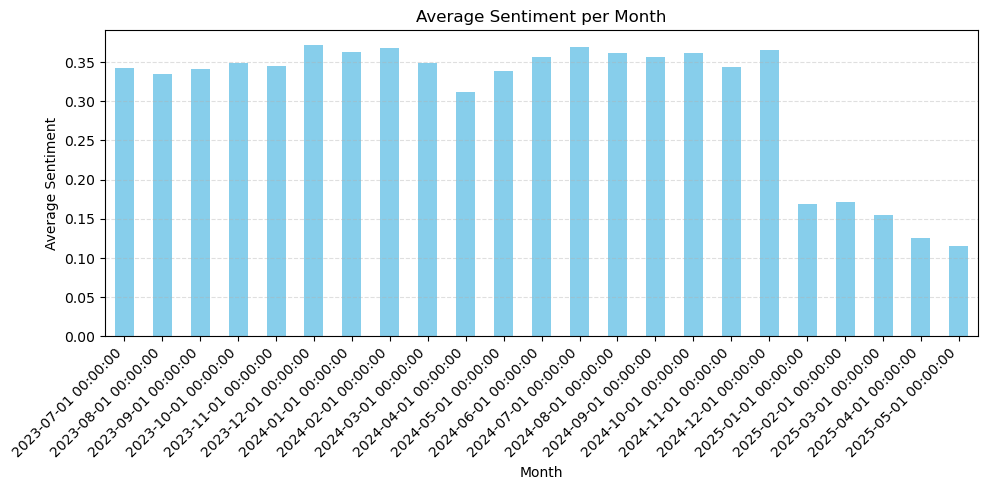

In [19]:
df["createdAt_clean"] = (
    df["createdAt"]
    .astype(str)
    .str.replace(r"\+00:00Z$", "Z", regex=True)
)

df["createdAt_dt"] = pd.to_datetime(
    df["createdAt_clean"],
    errors="coerce",
    utc=True
)

df_valid = df[df["createdAt_dt"].notna()].copy()

df_valid["month"] = pd.to_datetime(df_valid["createdAt_dt"].dt.strftime("%Y-%m"))

monthly_avg = df_valid.groupby("month")["sentiment"].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind="bar", color="skyblue", title="Average Sentiment per Month")
plt.xlabel("Month")
plt.ylabel("Average Sentiment")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()